In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/My Drive/lucho/color-sketch/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
from shutil import copyfile
import cv2
import numpy as np
import pandas as pd
from datetime import datetime
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, Input, Add, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

# **Data Preprocessing**

In [3]:
#Load Name of files.
img_name_sketch = []

# Only processing first 8 folders
for i in tqdm(range(8)): 
  folder=i.__str__().zfill(4)
  loc = './images/sketch/' + folder + '/'
  for filename in os.listdir(loc):
    img_name_sketch.append(folder+'/'+filename)
  
print('Total number of sketch images:',len(img_name_sketch))
    
#Load Name of files.
img_name_src = []

#Processing first 8 folders
for i in  tqdm(range(8)):
  folder=i.__str__().zfill(4) 
  loc = './images/src/' + folder + '/'
  for filename in os.listdir(loc):   
    img_name_src.append(folder+'/'+filename) 

print('Total number of color images:',len(img_name_src))

# Generate train, validation and test images
img_train  = img_name_sketch[0:12000]
img_val = img_name_sketch[12000:13500]
img_test = img_name_sketch[13500:15000]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Total number of sketch images: 15806


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



Total number of color images: 15806


In [0]:
#Function to generate batch of images for model training.
def generate_batch_images(img_idx, arr, n_samples):
  
  #Arrays to store batch sample of sketches and color images.
  X_sketches = []
  X_color = []

  #Loop to generate sketeches and color image arrays.
  for i in range(n_samples):
    
    #Location for sketch images.
    loc = './images/sketch/'
    #Read the image.
    img = load_img(loc+arr[(i + img_idx) % len(arr)])
    img = img_to_array(img)
    #Append image array in the list.
    X_sketches.append(img)

    #Location for color images.
    loc = './images/src/'
    #Read the image.
    img = load_img(loc+arr[(i + img_idx) % len(arr)])
    img = img_to_array(img)
    #Append image array in the list.
    X_color.append(img)

  #Update train batch pointer.
  img_idx +=  n_samples
  
  #Converting list to arrays.
  X_sketches = np.array(X_sketches)
  X_color = np.array(X_color)

  #Normalize data to -1 to +1 format.
  X_sketches = (X_sketches - 127.5) / 127.5
  X_color = (X_color - 127.5) / 127.5

  #return batch of sketches and color images.
  return img_idx, X_sketches, X_color

In [0]:
# functioon to display images
def display_image(img_array):
  #Convertng the generated image back to 0-255 value format.
  img = ((img_array + 1)/2.0)*255.0
  img = array_to_img(img)
  #Show image
  plt.imshow(img)
  plt.show()

sketch


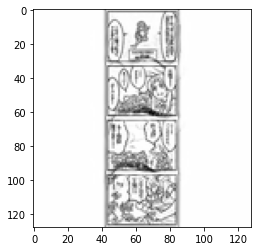

color


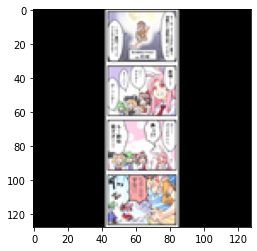

sketch


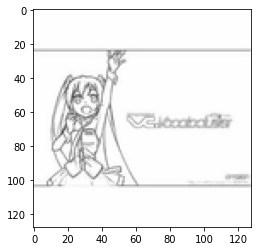

color


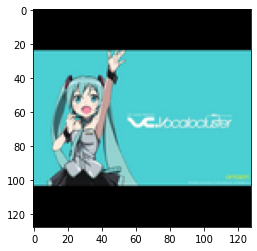

sketch


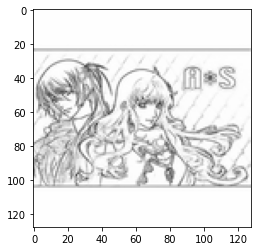

color


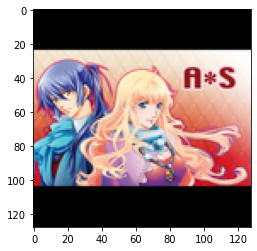

In [0]:
#Print some sample of images.
img_arr = []
col_arr = []

n_samples = 3

# index for creating batch images
train_batch_idx = 0
val_batch_idx = 0

#Generate batch of skecth and corresponding color images.
train_batch_idx, img_arr, col_arr = generate_batch_images(train_batch_idx, img_train, n_samples)

#Print generated images.
for i in range(n_samples):
  print('sketch')
  display_image(img_arr[i])

  print('color')
  display_image(col_arr[i])

# **U-Net Keras Model**

In [0]:
#Function to generate U-net Model.
#For the Generator Architecture referred - https://github.com/kvfrans/deepcolor/blob/master/main.py.

def color_image():

    #Encoder Unit
    #Input Layer (128, 128, 3)
    encoder_input = Input(shape=(128, 128, 3,)) 
    #Layer-1 Output image of shape - 64 * 64 * 64
    encoder_output_1 = Conv2D(64, (5,5), padding='same',  strides=2)(encoder_input) 
    #Leaky ReLUs allow a small, non-zero gradient when the unit is not active. 
    encoder_output_2 = LeakyReLU(alpha=0.2)(encoder_output_1)  
    #Layer-2 Output image of shape - 32 * 32 * 128
    encoder_output_2 = Conv2D(128, (5,5),  padding='same', strides=2)(encoder_output_2)
    #Batch Normalization.
    encoder_output_2 = BatchNormalization(momentum=0.9)(encoder_output_2)
    #Layer-3 Output image of shape - 16 * 16 * 256
    encoder_output_3 = LeakyReLU(alpha=0.2)(encoder_output_2)
    encoder_output_3 = Conv2D(256, (5,5),  padding='same',  strides=2)(encoder_output_3)
    encoder_output_3 = BatchNormalization(momentum=0.9)(encoder_output_3)
    #Layer-4 Output image of shape - 8 * 8 * 512
    encoder_output_4 = LeakyReLU(alpha=0.2)(encoder_output_3)
    encoder_output_4 = Conv2D(512, (5,5),  padding='same',  strides=2)(encoder_output_4)
    encoder_output_4 = BatchNormalization(momentum=0.9)(encoder_output_4)
    #Layer-5 Output image of shape - 4 * 4 * 512
    encoder_output_5 = LeakyReLU(alpha=0.2)(encoder_output_4)
    encoder_output_5 = Conv2D(512, (5,5),  padding='same',  strides=2)(encoder_output_5)
    encoder_output_5 = BatchNormalization(momentum=0.9)(encoder_output_5)
    

    
    #Decoder Unit
    #Conv2DTranspose - The need for transposed convolutions generally arises from the desire to use a transformation going in the opposite 
    #direction of a normal convolution, i.e., from something that has the shape of the output of some convolution to 
    #something that has the shape of its input while maintaining a connectivity pattern that is compatible with said convolution.
    #Ref- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose
    #Layer-6 Output image of shape - 8 * 8 * 512
    encoder_output_6 = Conv2DTranspose(512, (5,5), padding='same', activation='relu', strides=2)(encoder_output_5)
    encoder_output_6  = BatchNormalization(momentum=0.9)(encoder_output_6)
    #Concatenating output from previous layer with output from layer-4. Both are of same dimension.
    encoder_output_6 = Add()([encoder_output_6, encoder_output_4])
    #Layer-7 Output image of shape - 16 * 16 * 256
    encoder_output_7 = Conv2DTranspose(256, (5,5), padding='same', activation='relu', strides=2)(encoder_output_6)
    encoder_output_7  = BatchNormalization(momentum=0.9)(encoder_output_7)
    #Concatenating output from previous layer with output from layer-3. Both are of same dimension.
    encoder_output_7 = Add()([encoder_output_7, encoder_output_3])
    #Layer-8 Output image of shape - 32 * 32 * 128
    encoder_output_8 = Conv2DTranspose(128, (5,5), padding='same', activation='relu', strides=2)(encoder_output_7)
    encoder_output_8  = BatchNormalization(momentum=0.9)(encoder_output_8)
    #Concatenating output from previous layer with output from layer-2. Both are of same dimension.
    encoder_output_8 = Add()([encoder_output_8, encoder_output_2]) 
    #Layer-9 Output image of shape - 64 * 64 * 64
    encoder_output_9 = Conv2DTranspose(64, (5,5), padding='same', activation='relu', strides=2)(encoder_output_8)
    encoder_output_9  = BatchNormalization(momentum=0.9)(encoder_output_9)
    #Concatenating output from previous layer with output from layer-1. Both are of same dimension
    encoder_output_9 = Add()([encoder_output_9, encoder_output_1]) 
    #Layer-10 (Output Layer) Output image of shape - 128 * 128 * 3
    encoder_output = Conv2DTranspose(3, (5,5), padding='same', activation='tanh', strides=2)(encoder_output_9)
    
    #Defining Model with input and Outputs.
    model = Model(encoder_input, encoder_output)

    #Adam Optimizer.
    opt = Adam(lr=0.0002, beta_1=0.5)  
    
    #Compile Model with Adam Optimizer and Mean Absolute Error.
    model.compile(optimizer=opt, loss=['mae'])
    #Return Model.
    return model

In [0]:
#Calling the U-net model defined above and print its summary.
model = color_image()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   4864        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  204928      leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [0]:
#Plot model performance.
def plot_history(tr_loss, val_loss):
# plot Loss
 plt.plot(tr_loss, label='Training Loss')
 plt.plot(val_loss, label='Validation Loss')
 plt.gca().set_title("Model Loss")
 plt.legend()
 plt.show()

In [0]:
# If already exists, load trained model
if os.path.exists('model/color_sketch_model_weights.h5'):
  # Generate model architecure
  model = color_image()

  # Load weights from model trained above.
  model.load_weights('model/color_sketch_model_weights.h5')

  print('Model Loaded OK!')

else:
  model = color_image()
  print('Did not find any trained model, starting a new one.')

# If already exists, load trained model loss and define last training epoch
if os.path.exists('model/loss_metrics.csv'):
  # Load model metrics
  model_metrics = pd.read_csv('model/loss_metrics.csv')
  last_epoch = model_metrics['epoch'].max()
  print('Model metrics loaded OK!')

else:
  model_metrics = pd.DataFrame()
  last_epoch = 0
  print('Did not find any model metrics file, starting a new one.')


Model Loaded OK!
Model metrics loaded OK!


### *Training Session*

In [0]:
# Training for 150 more epochs.
epochs = 150
batch_size = 16

# Number of images in train set
len_training_images = len(img_train)

# Training for number of epochs.
print('Starting Tranining Session...')
for e in tqdm(range(last_epoch, epochs)):
  
  # Initiate batch counter
  train_batch_idx = 0
  val_batch_idx = 0

  #Looping for number of iterations so that all images gets processed atleast once in epoch.
  for i in tqdm(range(len_training_images//batch_size)):
    #Generate batch of images from train set.
    train_batch_idx, xs, ys = generate_batch_images(train_batch_idx, img_train, batch_size)
   
    #Train model on above data. 
    tr_loss = model.train_on_batch(xs,ys)

    #Generate batch of images from validation set.
    val_batch_idx, xs, ys = generate_batch_images(val_batch_idx, img_val, batch_size)

    #Test model on above data. 
    val_loss = model.test_on_batch(xs,ys)    

    #Append performances.
    model_metrics_add = pd.DataFrame({'epoch': [e],
                                      'training_loss': [tr_loss],
                                      'validation_loss': [val_loss]})
    model_metrics = pd.concat([model_metrics, model_metrics_add], axis=0)
 
  #Show results after each epoch.
  print('Epoch number: {}'.format(e))
  print('Training Loss:',tr_loss)
  print('Validation Loss:',val_loss)

  #Saving the model and metrics file
  model.save_weights('model/color_sketch_model_weights.h5')
  model.save('model/color_sketch_model.h5', save_format='h5')
  model.save('model/color_sketch_model/1', save_format='tf')
  model_metrics.to_csv('model/loss_metrics.csv', index=False)

Starting Tranining Session...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



Epoch number: 16
Training Loss: 0.05940042436122894
Validation Loss: 0.250092476606369
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 17
Training Loss: 0.061331868171691895
Validation Loss: 0.3277639150619507
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 18
Training Loss: 0.06091172993183136
Validation Loss: 0.25028663873672485
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 19
Training Loss: 0.060709647834300995
Validation Loss: 0.2659108638763428
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 20
Training Loss: 0.06089606136083603
Validation Loss: 0.25369757413864136
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 21
Training Loss: 0.06098359078168869
Validation Loss: 0.27763426303863525
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 22
Training Loss: 0.06095351278781891
Validation Loss: 0.2506580352783203
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 23
Training Loss: 0.06071127578616142
Validation Loss: 0.2506555914878845
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 24
Training Loss: 0.06028902903199196
Validation Loss: 0.26213350892066956
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 25
Training Loss: 0.060718290507793427
Validation Loss: 0.25961780548095703
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 26
Training Loss: 0.06091984361410141
Validation Loss: 0.2578276991844177
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 27
Training Loss: 0.060139235109090805
Validation Loss: 0.2529046833515167
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 28
Training Loss: 0.060375653207302094
Validation Loss: 0.25396832823753357
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 29
Training Loss: 0.06097191572189331
Validation Loss: 0.26984718441963196
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 30
Training Loss: 0.06036234274506569
Validation Loss: 0.24852591753005981
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 31
Training Loss: 0.06068769097328186
Validation Loss: 0.2541801631450653
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 32
Training Loss: 0.06059994176030159
Validation Loss: 0.338736891746521
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 33
Training Loss: 0.06027214229106903
Validation Loss: 0.254291296005249
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 34
Training Loss: 0.060349032282829285
Validation Loss: 0.2511541247367859
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 35
Training Loss: 0.05967335402965546
Validation Loss: 0.263716459274292
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 36
Training Loss: 0.05995439738035202
Validation Loss: 0.2666770815849304
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 37
Training Loss: 0.05968600884079933
Validation Loss: 0.26152506470680237
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 38
Training Loss: 0.05990342050790787
Validation Loss: 0.25693196058273315
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 39
Training Loss: 0.061446964740753174
Validation Loss: 0.307584285736084
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 40
Training Loss: 0.05952884256839752
Validation Loss: 0.25837987661361694
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 41
Training Loss: 0.060939524322748184
Validation Loss: 0.2518816292285919
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 42
Training Loss: 0.06084144860506058
Validation Loss: 0.26465731859207153
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 43
Training Loss: 0.059830762445926666
Validation Loss: 0.2552207112312317
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 44
Training Loss: 0.05933838337659836
Validation Loss: 0.25516045093536377
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 45
Training Loss: 0.06003434583544731
Validation Loss: 0.25780823826789856
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 46
Training Loss: 0.060551974922418594
Validation Loss: 0.25333988666534424
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 47
Training Loss: 0.059525132179260254
Validation Loss: 0.25173258781433105
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 48
Training Loss: 0.05957760661840439
Validation Loss: 0.2552754282951355
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 49
Training Loss: 0.059048864990472794
Validation Loss: 0.25170329213142395
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 50
Training Loss: 0.059154778718948364
Validation Loss: 0.2662201523780823
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 51
Training Loss: 0.060071054846048355
Validation Loss: 0.2560803294181824
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 52
Training Loss: 0.05915292352437973
Validation Loss: 0.2767941355705261
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 53
Training Loss: 0.059247590601444244
Validation Loss: 0.25476300716400146
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 54
Training Loss: 0.06065116450190544
Validation Loss: 0.26036569476127625
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 55
Training Loss: 0.05983080714941025
Validation Loss: 0.249349907040596
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 56
Training Loss: 0.059903502464294434
Validation Loss: 0.25744813680648804
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 57
Training Loss: 0.05852384865283966
Validation Loss: 0.25252172350883484
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets



Epoch number: 58
Training Loss: 0.05901477485895157
Validation Loss: 0.25615939497947693
INFO:tensorflow:Assets written to: model/color_sketch_model/1/assets


Buffered data was truncated after reaching the output size limit.

### *Model Performance*

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


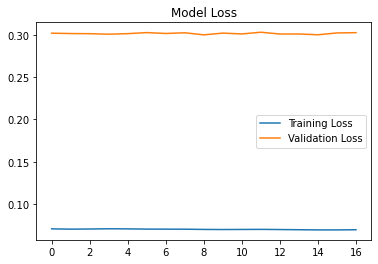

In [0]:
# Plot model metrics
epoch_model_metrics = model_metrics.groupby('epoch')['training_loss','validation_loss'].mean()
plot_history(epoch_model_metrics['training_loss'].values, epoch_model_metrics['validation_loss'].values) 

Train data : sketch image


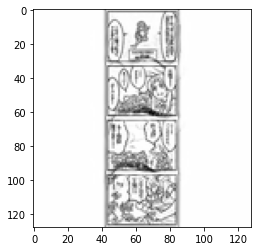

Train data : color image


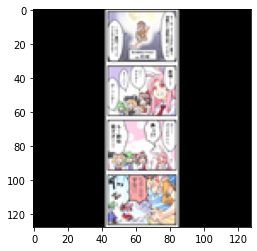

Train data : Generated image


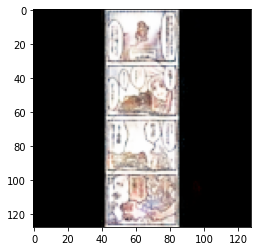

Train data : sketch image


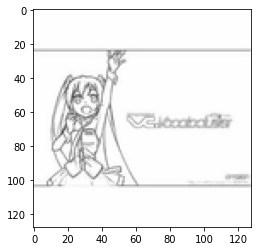

Train data : color image


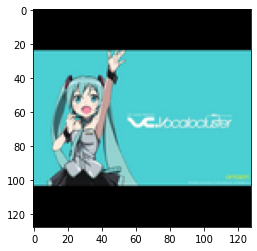

Train data : Generated image


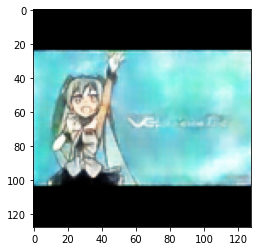

Train data : sketch image


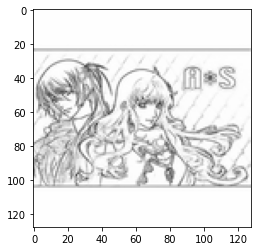

Train data : color image


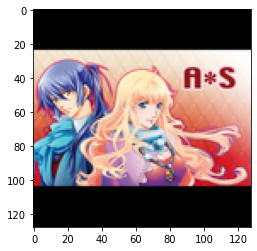

Train data : Generated image


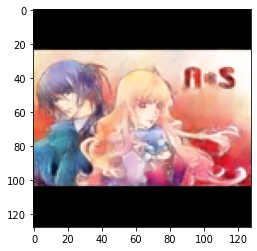

Validation data : sketch image


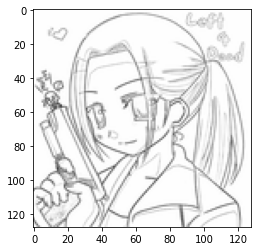

Validation data : color image


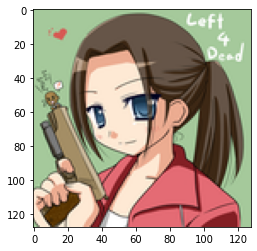

Validation data : Generated image


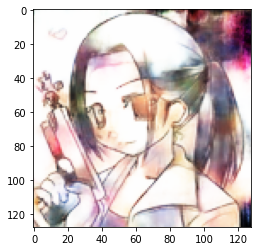

Validation data : sketch image


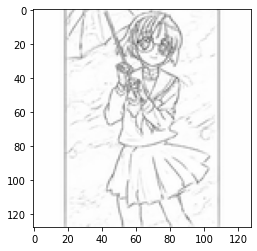

Validation data : color image


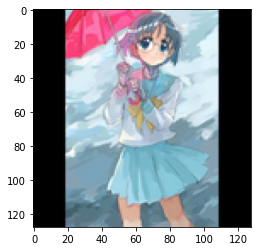

Validation data : Generated image


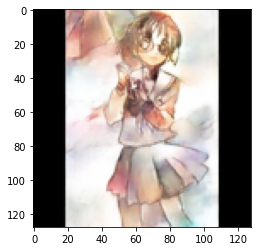

Validation data : sketch image


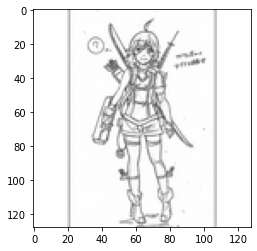

Validation data : color image


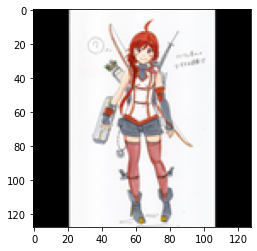

Validation data : Generated image


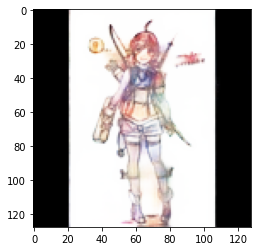

Test data : sketch image


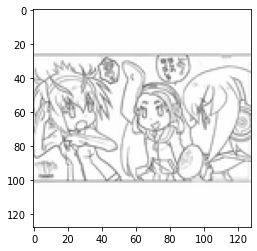

Test data : color image


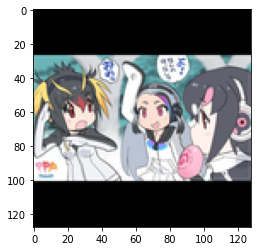

Test data : Generated image


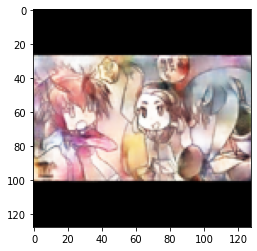

Test data : sketch image


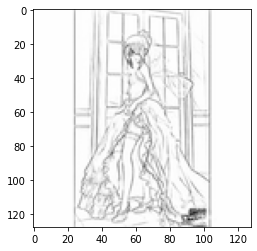

Test data : color image


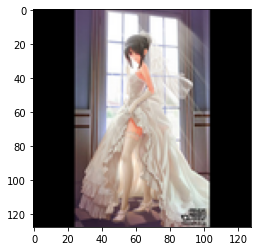

Test data : Generated image


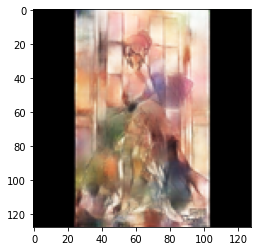

Test data : sketch image


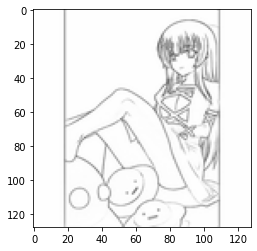

Test data : color image


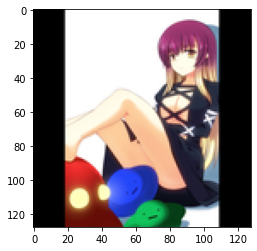

Test data : Generated image


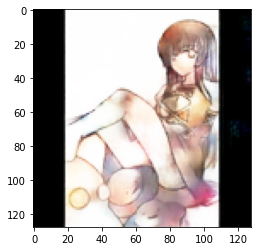

In [0]:
#Show generated images.
n_samples = 3 

#Resetting pointers to zero.
train_batch_idx = 0
val_batch_idx = 0
test_batch_idx = 0

#Generate batch of skecth and corresponding color images.
train_batch_idx, X_tr, Y_tr = generate_batch_images(train_batch_idx, img_train, n_samples)
val_batch_idx, X_val, Y_val = generate_batch_images(val_batch_idx, img_val, n_samples)
test_batch_idx, X_test, Y_test = generate_batch_images(test_batch_idx, img_test, n_samples)

#Function to generate n samples generated image from each train, validation and test data.
def print_results(model, n_samples):
  
  #Generate image prediction train data.
  pred_tr = model.predict(X_tr)

  for i in range(n_samples):
    print('Train data : sketch image')
    display_image(X_tr[i])

    print('Train data : color image')
    display_image(Y_tr[i])

    print('Train data : Generated image')
    display_image(pred_tr[i])
  
  #Generate image prediction validation data.
  pred_val = model.predict(X_val)

  for i in range(n_samples):
    print('Validation data : sketch image')
    display_image(X_val[i])

    print('Validation data : color image')
    display_image(Y_val[i])

    print('Validation data : Generated image')
    display_image(pred_val[i])
    
  #Generate image on 10 samples from test data.
  pred_test = model.predict(X_test)
  
  for i in range(n_samples):
    print('Test data : sketch image')
    display_image(X_test[i])

    print('Test data : color image')
    display_image(Y_test[i])

    print('Test data : Generated image')
    display_image(pred_test[i])

# Print 10 samples
print_results(model, n_samples)

Original Sketch Image:


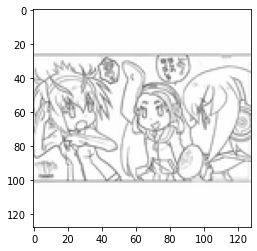

Original Color Image:


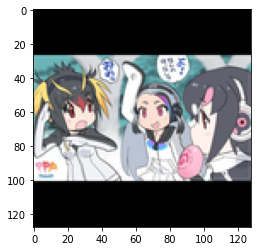

Image generated with model: model_025.h5


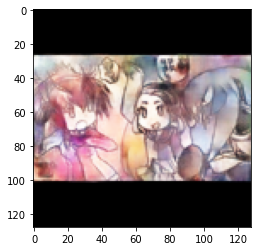

Image generated with model: model_050.h5


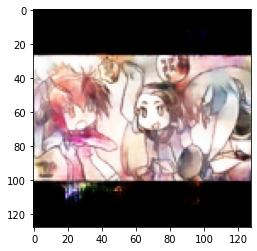

Image generated with model: model_075.h5


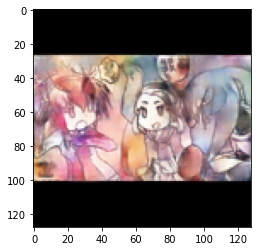

Image generated with model: model_0100.h5


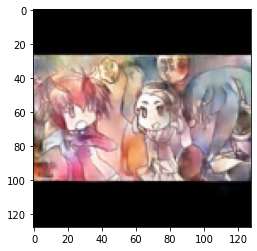

Image generated with model: model/color_sketch_model_weights.h5


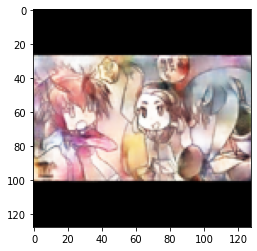

In [0]:
# Show image training evolution
model_list = ['model_025.h5','model_050.h5','model_075.h5','model_0100.h5','model/color_sketch_model_weights.h5']

# Test batch images
test_batch_idx = 0
test_batch_idx, X_test, Y_test = generate_batch_images(test_batch_idx, img_test, 10)

# display original sketch image
print('Original Sketch Image:')
display_image(X_test[0])

# display original color image
print('Original Color Image:')
display_image(Y_test[0])

# Display different epoch's prediction
for i in model_list:
  # Create model and load weights
  model = color_image()
  model.load_weights(i)

  # Generate predictions
  pred = model.predict(X_test)
  pred = pred[0]

  # Display generated image
  print('Image generated with model: {}'.format(i))
  display_image(pred)
